# CAPSTONE - Plant Disease

### Library

Import some library that will be used.

In [26]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

### Import Data

Read the directory of data that already split into three, that are training (80%), validation (10%), testing (10%).

In [2]:
train_dir = 'D:/Hafizh/Dataset/training'
val_dir = 'D:/Hafizh/Dataset/validation'
test_dir = 'D:/Hafizh/Dataset/testing'

In [16]:
image_width, image_height = 150, 150
batch_size = 128
num_epochs = 20
num_classes = len(os.listdir(train_dir))
print(num_classes)

45


There are total of 45 number of classes that contains healthy and diseased leaf image that will be used in this project.

### See some sample images from training data

Defining sample train data that included images array and labels array. Then, we see the labels in that 45 classes.

In [18]:
def sample_train_data():
    image_size = image_width,image_height
    imgs_array = []
    labels_array = []
    for folder in sorted(os.listdir(train_dir)):
        for file in sorted(os.listdir(train_dir + '/' + folder)):
            sub_file = train_dir + '/' + folder + '/' + file
            final_img = plt.imread(sub_file)
            imgs_array.append(final_img)
            labels_array.append(folder)
            break
    return imgs_array, labels_array

imgs_array, labels_array = sample_train_data()
print("Labels: ", labels_array)

Labels:  ['Apple_Black_Rot', 'Apple_Cedar_Apple_Rust', 'Apple_Healthy', 'Apple_Scab', 'Bell_Pepper_Bacterial_Spot', 'Bell_Pepper_Healthy', 'Blueberry_Healthy', 'Cherry_Healthy', 'Cherry_Powdery_Mildew', 'Corn_Cercospora', 'Corn_Common_Rust', 'Corn_Healthy', 'Corn_Northern', 'Grape_Black_Rot', 'Grape_Blight', 'Grape_Esca', 'Grape_Healthy', 'Peach_Bacterial_Spot', 'Peach_Healthy', 'Pomegranate_Diseased', 'Pomegranate_Healthy', 'Potato_Early_Blight', 'Potato_Healthy', 'Potato_Late_Blight', 'Rice_Brown_Spot', 'Rice_Healthy', 'Rice_Leaf_Blast', 'Rice_Neck_Blast', 'Soybean_Healthy', 'Squash_Powdery_Mildew', 'Strawberry_Healthy', 'Strawberry_Leaf_Scorch', 'Tomato_Bacterial_Spot', 'Tomato_Early_Blight', 'Tomato_Healthy', 'Tomato_Late_Blight', 'Tomato_Leaf_Mold', 'Tomato_Mosaic_Virus', 'Tomato_Septoria_Leaf_Spot', 'Tomato_Spider_Mites_Two_Spotted_Spider_Mite', 'Tomato_Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Wheat_Brown_Rust', 'Wheat_Healthy', 'Wheat_Yellow_Rust']


See the sample of each directory in training data (a total of 45 classes)

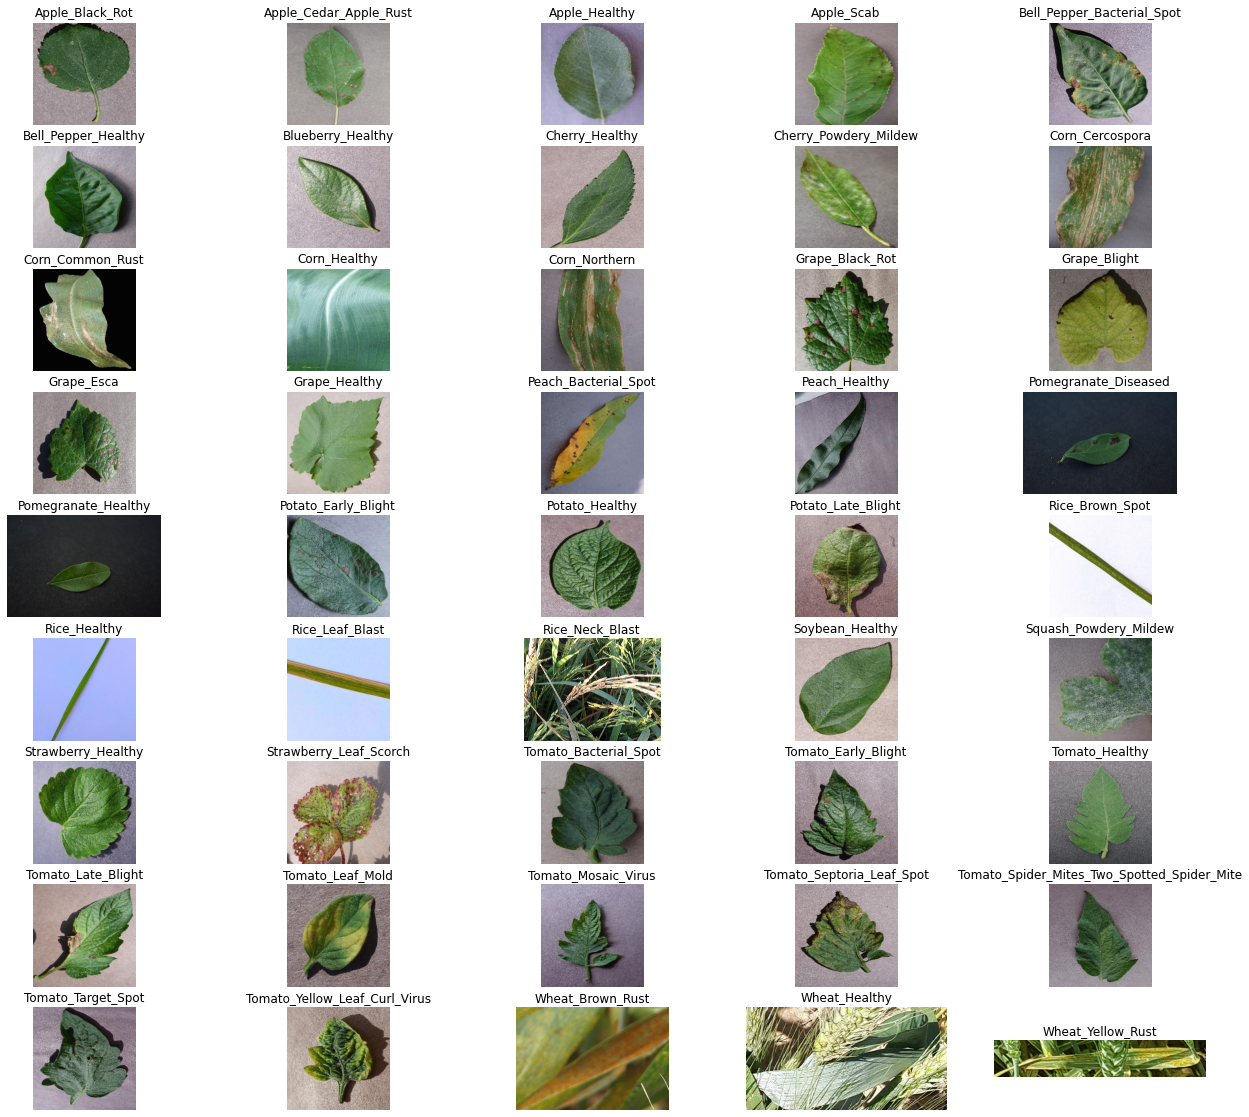

In [17]:
fig = plt.figure(figsize=(22, 20))
def plot_sample_images(fig, img, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(img,cmap='Greys')
    plt.title(label)
    return

image_index = 0
row = 9
col = 5
for i in range(1,(row*col+1)):
    plot_sample_images(fig, imgs_array[image_index], labels_array[image_index], row, col, i)
    image_index +=  1
plt.show()

The image show a total of 45 image that include some healthy and diseased leaves of each classes.

### Preprocessing

Preprocessing done by using ImageDataGenerator that were provided by Keras. Here, we doing some data augmentation. For training data, we doing some parameter to the dataset, meanwhile for the validation data and testing data we only doing rescale to the dataset.

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

Pass the parameter in ImageDataGenerator to each training data, validation data, and testing data using flow_from_directory method

In [5]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8879 images belonging to 45 classes.
Found 1109 images belonging to 45 classes.
Found 1109 images belonging to 45 classes.


The output show that there are 8879 training data, 1109 validation data, and also 1109 testing data that all of them belong to 45 class.

### Model

MobileNet

We are doing transfer learning with MobileNet architecture. MobileNets is a Convolutional Neural Network (CNN) architecture that focus on optimizing latency but at the same time also yield small networks.

In [11]:
IMG_SHAPE=(image_width,image_height, 3)
mobnet_model = tf.keras.applications.MobileNet(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

In [12]:
mobnet_model.trainable = True
mobnet_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 151, 151, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 75, 75, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 75, 75, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 75, 75, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 75, 75, 32) 

The output show the summary of MobileNet model that included layer name, type of layer, output shape, and parameters. From this original model, we will add some layers and also adding last Dense output with 45 classes and softmax activation.

In [10]:
#Adding Layers
model = Sequential()
model.add(mobnet_model)
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
conv2d (Conv2D)              (None, 4, 4, 128)         1179776   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 45)                1

The final model show a total parameters of 4.551.533 with details that there are 4.529.645 trainable parameters and 21.888 non-trainable parameters.

### Running Epochs

Then, we do training epochs with optimizer Adam, learning rate 0.001, loss categorical cross-entropy, and metrics accuracy. We also added Model Checkpoint to temporary save the best validation loss.

In [12]:
#from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
ckpt = ModelCheckpoint("LeaveDisease.hdf5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

history = model.fit(
    train_data,
    steps_per_epoch = train_data.n // batch_size,
    validation_data = val_data,
    validation_steps = val_data.n // batch_size,
    callbacks = [ckpt],
    epochs=num_epochs)

Epoch 1/20
69/69 [==============================] - ETA: 0s - loss: 2.2657 - accuracy: 0.4184 
Epoch 00001: val_loss improved from inf to 3.67185, saving model to LeaveDisease.hdf5
69/69 [==============================] - 1876s 27s/step - loss: 2.2657 - accuracy: 0.4184 - val_loss: 3.6718 - val_accuracy: 0.2363
Epoch 2/20
69/69 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.7839 
Epoch 00002: val_loss improved from 3.67185 to 1.02290, saving model to LeaveDisease.hdf5
69/69 [==============================] - 1653s 24s/step - loss: 0.6997 - accuracy: 0.7839 - val_loss: 1.0229 - val_accuracy: 0.6836
Epoch 3/20
69/69 [==============================] - ETA: 0s - loss: 0.4449 - accuracy: 0.8662 
Epoch 00003: val_loss improved from 1.02290 to 0.94829, saving model to LeaveDisease.hdf5
69/69 [==============================] - 1673s 24s/step - loss: 0.4449 - accuracy: 0.8662 - val_loss: 0.9483 - val_accuracy: 0.7275
Epoch 4/20
69/69 [==============================] - E

The last epoch show a training loss in amount of 0.1491 and validation loss 0.5429. Then, for the accuracy, a 0.9557 training accuracy and 0.8711 validation accuracy.

In [13]:
model.save(r'D:/Hafizh/Plant_Disease_Model_MobileNet_150.h5',save_format='h5')

The model will be saved in h5 format in internal directory.

In [20]:
model=tf.keras.models.load_model('D:/Hafizh/Plant_Disease_Model_MobileNet_150.h5')

### Model Evaluation

Accuracy Plot and Loss Plot

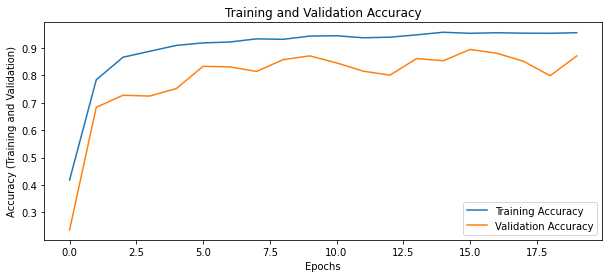

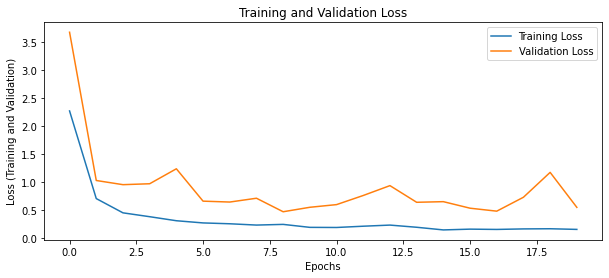

In [15]:
#Accuracy Plot
plt.figure(figsize=(10, 4))
plt.plot(history.history["accuracy"],label="Training Accuracy")
plt.plot(history.history["val_accuracy"],label="Validation Accuracy")
plt.legend()
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (Training and Validation)")
plt.xlabel("Epochs")
plt.show()

#Loss Plot
plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.title('Training and Validation Loss')
plt.ylabel("Loss (Training and Validation)")
plt.xlabel("Epochs")
plt.show()

The accuracy and loss plot showing a great improve from one epoch to the next epoch.

### Evaluation of Test Set

In [19]:
x_test = []
y_test = []
class_names = []

for i,test_major_folder in enumerate(os.listdir(test_dir)):
    print(i,test_major_folder)
    class_names.append(test_major_folder)
    test_folder_dir = os.path.join(test_dir,test_major_folder)
    test_files = os.listdir(test_folder_dir)
    for file in test_files:
        test_file_path = os.path.join(test_folder_dir,file)
        image = load_img(test_file_path,target_size=(150,150))
        image = img_to_array(image)/255.
        x_test.append(image)
        y_test.append(i)

x_test = np.array(x_test)
y_test = to_categorical(y_test)

0 Apple_Black_Rot
1 Apple_Cedar_Apple_Rust
2 Apple_Healthy
3 Apple_Scab
4 Bell_Pepper_Bacterial_Spot
5 Bell_Pepper_Healthy
6 Blueberry_Healthy
7 Cherry_Healthy
8 Cherry_Powdery_Mildew
9 Corn_Cercospora
10 Corn_Common_Rust
11 Corn_Healthy
12 Corn_Northern
13 Grape_Black_Rot
14 Grape_Blight
15 Grape_Esca
16 Grape_Healthy
17 Peach_Bacterial_Spot
18 Peach_Healthy
19 Pomegranate_Diseased
20 Pomegranate_Healthy
21 Potato_Early_Blight
22 Potato_Healthy
23 Potato_Late_Blight
24 Rice_Brown_Spot
25 Rice_Healthy
26 Rice_Leaf_Blast
27 Rice_Neck_Blast
28 Soybean_Healthy
29 Squash_Powdery_Mildew
30 Strawberry_Healthy
31 Strawberry_Leaf_Scorch
32 Tomato_Bacterial_Spot
33 Tomato_Early_Blight
34 Tomato_Healthy
35 Tomato_Late_Blight
36 Tomato_Leaf_Mold
37 Tomato_Mosaic_Virus
38 Tomato_Septoria_Leaf_Spot
39 Tomato_Spider_Mites_Two_Spotted_Spider_Mite
40 Tomato_Target_Spot
41 Tomato_Yellow_Leaf_Curl_Virus
42 Wheat_Brown_Rust
43 Wheat_Healthy
44 Wheat_Yellow_Rust


See the shape of x test and y test

In [21]:
print(x_test.shape)
print(y_test.shape)

(1109, 150, 150, 3)
(1109, 45)


Evaluate the test set by seeing the test accuracy and test loss.

In [22]:
loss, accuracy = model.evaluate(test_data)
print('Test Accuracy:', accuracy)
print('Test Loss:', loss)

9/9 [==============================] - 209s 23s/step - loss: 0.5457 - accuracy: 0.8873
Test Accuracy: 0.8872858285903931
Test Loss: 0.5457251667976379


See predictions of the test set

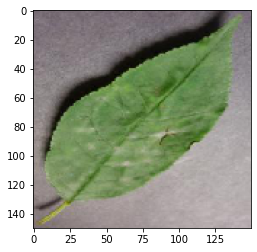

The True Class: 8 : Cherry_Powdery_Mildew
The Predicted Class: 8 : Cherry_Powdery_Mildew
The model can predict the right class


In [25]:
#set some number first
n = 200

plt.imshow(x_test[n])
plt.show()

true_label = np.argmax(y_test,axis=1)[n]
print("The True Class:",true_label,":",class_names[true_label])

prediction = model.predict(x_test[n][np.newaxis,...])[0]

predicted_label = np.argmax(prediction)
print("The Predicted Class:",predicted_label,":",class_names[predicted_label])

if true_label == predicted_label:
    print("The model can predict the right class")
else:
    print("The model fail to predict the right class")

### Confusion Matrix

We will make a confusion matrix to see the proportion of right prediction for every class

In [27]:
#true label
y_true = np.argmax(y_test,axis=1)

#prediction label
Y_pred_from_model = model.predict(x_test)
y_pred = np.argmax(Y_pred_from_model, axis=1)

print(y_true)
print(y_pred)

[ 0  0  0 ... 44 44 44]
[ 0  0  0 ... 44 44 44]


Normalized confusion matrix
[[1.   0.   0.   ... 0.   0.   0.  ]
 [0.   1.   0.   ... 0.   0.   0.  ]
 [0.   0.   0.96 ... 0.   0.   0.  ]
 ...
 [0.   0.   0.   ... 0.92 0.08 0.  ]
 [0.   0.   0.   ... 0.   1.   0.  ]
 [0.   0.   0.   ... 0.04 0.   0.96]]


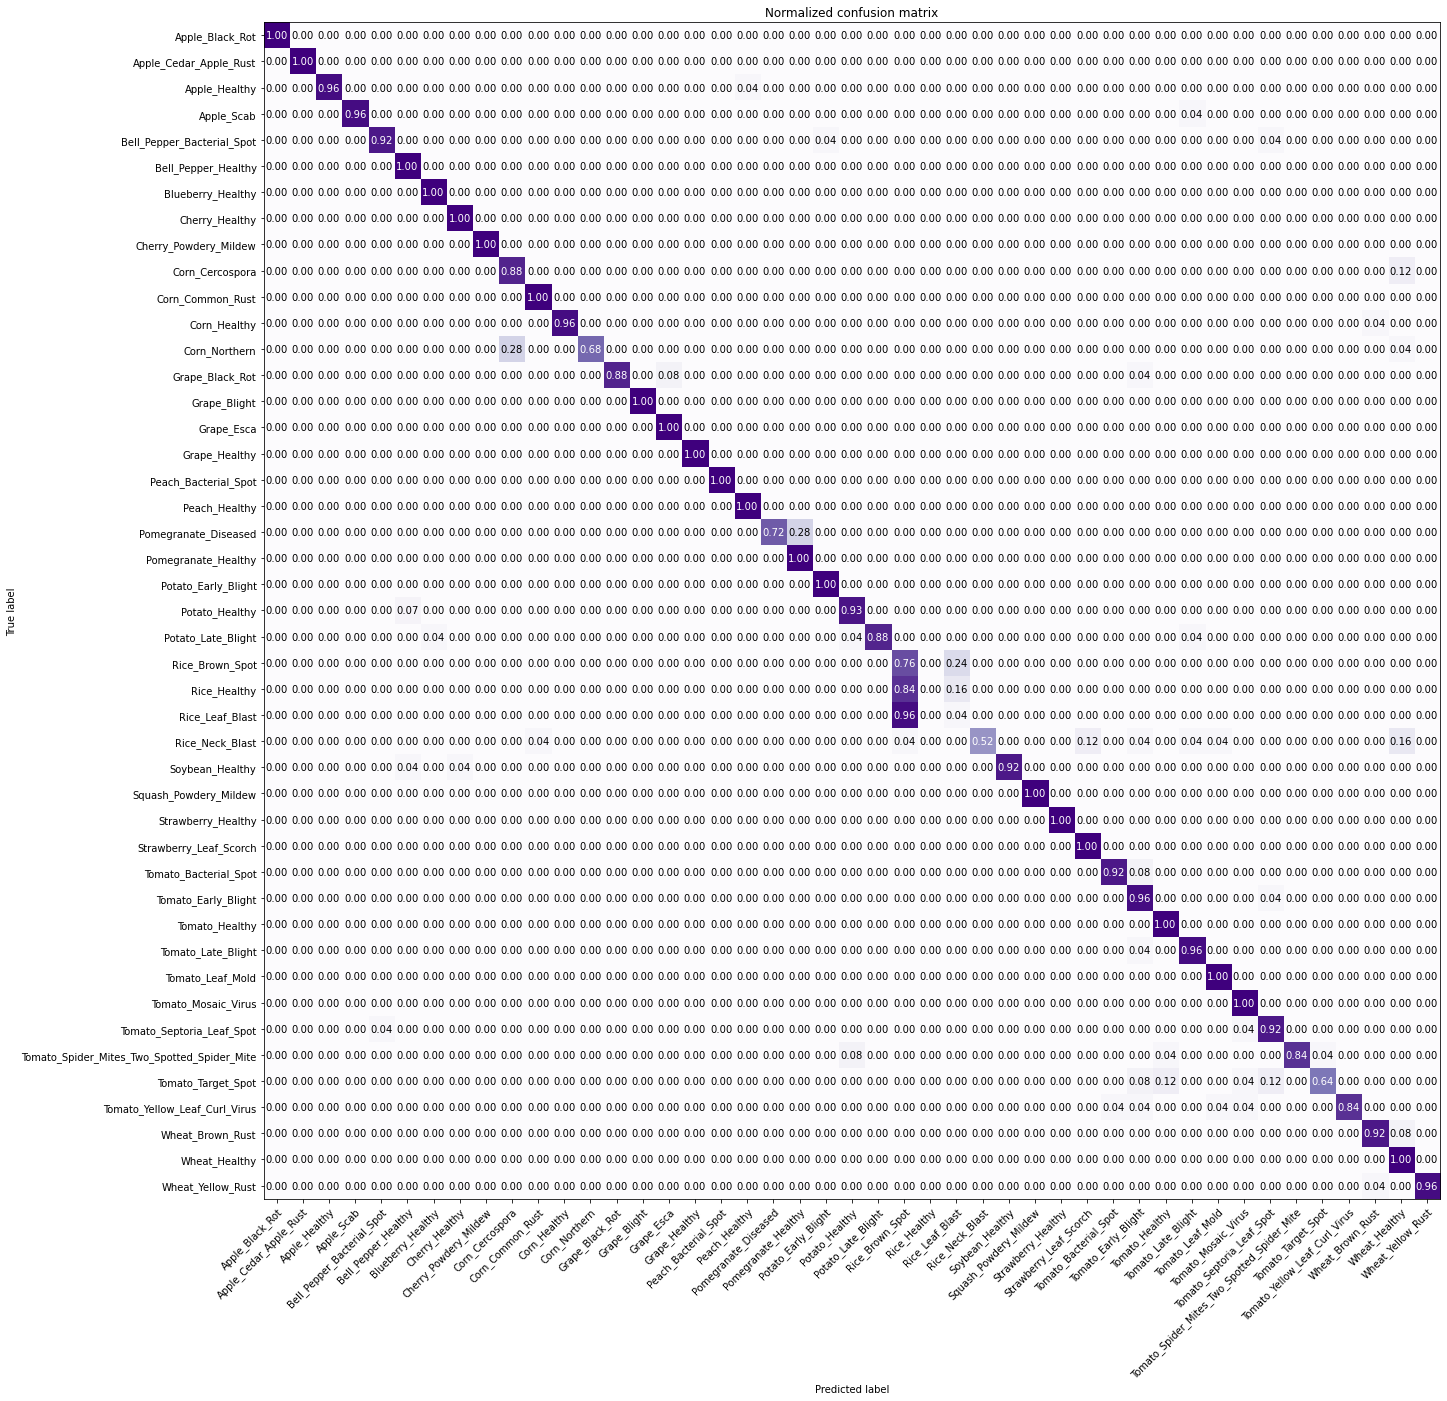

In [30]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Purples):

    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    #Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    #Rotate the tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #Loop over data dimensions
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

#Plot the Confusion Matrix
plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

The plot above showing the proportion of the right prediction label for every single class.

### Convert to Tensorflow Lite

Load the h5 model first

In [2]:
model=tf.keras.models.load_model('D:/Hafizh/Plant_Disease_Model_MobileNet_150.h5')
model

In [5]:
keras_file='D:/Hafizh/Plant_Disease_Model_MobileNet_150.h5'

Saving the model

In [6]:
tf.keras.models.save_model(model,keras_file)

In [7]:
from tensorflow.keras.models import Sequential, Model

Convert the model to tflite

In [9]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_save = converter.convert()

tflite_file='D:/Hafizh/STATISTIKA UNPAD/SEM 6/BANGKIT/MobileNet - 150x150/Plant_Disease_MobileNet_150.tflite'
with open(tflite_file,'wb') as f:
    f.write(tflite_save)